<a href="https://colab.research.google.com/github/Tommy-somen/pytorch/blob/master/udemy/2_NN%E3%83%A2%E3%83%87%E3%83%AB_DataLoader%E3%82%84%E3%83%9F%E3%83%8B%E3%83%90%E3%83%83%E3%83%81%E5%AD%A6%E7%BF%92%E3%81%AA%E3%81%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 演習
DataLoaderの扱いに慣れていきましょう。  
DataLoaderのコードを書いて、データの読み込みとミニバッチ法の実装を行います。



## データの読み込み
以下のセルにコードを追記し、DataLoaderの設定を行いましょう。  
以下のセルの`mnist_train`と`mnist_test`に対してDataLoaderを設定します。  

In [1]:
#モジュールの読み込み
import torch
  #MNISTの取得
from torchvision.datasets import MNIST
  #MNISTデータの変換
from torchvision import transforms
  #ミニバッチ学習を可能にするためのモジュール
from torch.utils.data import DataLoader 

# データの読み込み

In [2]:
#MNIST訓練データの読み込み
#MNIST("保存ディレクトリ", 訓練データかどうか, ダウンロードするかどうか、変換をどうするか？)
mnist_train = MNIST("./data", train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
#MNISTテストデータ
mnist_test = MNIST("./data", train=False, download=True, transform=transforms.ToTensor())

In [4]:
#データ量の確認
print("訓練データ：",len(mnist_train))
print("テストデータ：",len(mnist_test))

訓練データ： 60000
テストデータ： 10000


# DataLoaderによるミニバッチ作成

### 1. イメージデータのサイズを宣言しておく

In [5]:
#MNISTは28*28なので、今回は28に設定しておく
image_size = 28

#### 1-1.バッチサイズの宣言

In [6]:
#今回は256に設定する
batch_size = 256

#### 1-2. DataLoaderの利用

In [7]:
#DataLoaderの使い方
#DataLoader(データ, batch_size=バッチサイズ,shuffle=Boolen値)

#訓練データのバッチデータ作成
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

In [8]:
#train_loaderの中身を見てみると
#->[x_data, y_data]の順で格納されている
print(train_loader)

In [9]:
#テストデータのバッチデータ作成
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

## モデルの構築

### Pytorhでは、Sequencialのほか、モデルをクラスレベルで作成することも可能

### クラス作成に関するモジュールのインポート

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
#クラスmodelの作成
# -> __init__とforward(順伝播)を作成するのみでOK
class model(nn.Module):
  
  #初期化コンストラクタ
  def __init__(self):
    #super()による継承
    super().__init__()
    #ここからレイヤーを作成していく
    self.fc1 = nn.Linear(image_size*image_size, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128,10)

  #順伝播メソッド
  def forward(self,x):
    #xのバッチサイズと、入力サイズを設定 -> バッチサイズを-1にすると柔軟に設定してくれる
    x = x.view(-1, image_size*image_size )
    x = F.relu(self.fc1(x)) #1層目の後に活性化関数ReLUを適用する
    x = F.relu(self.fc2(x)) #2層目の後に活性化関数ReLUを適用する
    x = F.relu(self.fc3(x)) #3層目の後に活性化関数ReLUを適用する
    x = F.relu(self.fc4(x)) #4層目の後に活性化関数ReLUを適用する
    x = self.fc5(x)#出力層
    return x

In [12]:
#NNインスタンスの作成
model = model()

#NNmodelにGPUを設定する
model.cuda()
print(model)

model(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=10, bias=True)
)


## 学習
訓練および検証の箇所にfor文のコードを追記し、DataLoaderを使ったミニバッチ法を実装しましょう。  


In [13]:
#学習に関する最適化関数のモジュールインポート
from torch import optim

In [14]:
#損失関数の宣言 -> 交差エントロピー誤差関数
loss_func = nn.CrossEntropyLoss()

In [15]:
#最適化関数の宣言 ->SGD
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [16]:
#損失のログを格納するリストを作成
rec_loss_train = []
rec_loss_test = []

In [17]:
#学習（エポック=1000, バッチサイズ50)
epoch = 100

for i in range(epoch):

  #学習に関して###############

  #モデルを訓練モードに設定
  model.train()
  #訓練損失を初期として0に設定
  train_loss = 0

  ###ミニバッチ学習###
  for num, (x_train, y_train) in enumerate(train_loader):
    
    #x_train, y_trainについて、GPUを適用した変数をX,Yとする
    X, Y = x_train.cuda(), y_train.cuda()

    #Xを順伝播する
    y_hat = model(X)

    #y_hatと実際値の損失誤差lossを計算
    loss = loss_func(y_hat, Y)

    #ミニバッチ学習内での訓練損失を合算する
    train_loss += loss

    #最適化関数の勾配を0にリセットする
    #理由としては、Pytorchは逆伝播で計算した勾配を、以前計算していた勾配に加算する仕組みのため、今までの勾配を0にしておく
    optimizer.zero_grad()

    #逆伝播の勾配を計算する
    loss.backward()

    #計算した勾配を最適化関数に適用する
    optimizer.step()
    ###ミニバッチ学習ここまで###
  
  #1エポック内での訓練損失の平均を計算&格納
  train_loss /= num+1
  rec_loss_train.append(train_loss)
  #学習モードここまで###############
  
  #評価モード（テストデータでモデルを評価）###########

  #モデルを評価モードに設定
  model.eval()
  #テスト損失を初期化
  test_loss = 0

    ###テスト###
  for num, (x_test, y_test) in enumerate(test_loader):

    #x_train, y_trainについて、GPUを適用した変数をX,Yとする
    X, Y = x_test.cuda(), y_test.cuda()
    #Xを順伝播する
    y_hat = model(X)
    #y_hatと実際値の損失誤差lossを計算
    loss = loss_func(y_hat, Y)
    #ミニバッチ学習内での訓練損失を合算する
    test_loss += loss
    ###テストここまで###

  #1エポック内での訓練損失の平均を計算&格納
  test_loss /= num+1
  rec_loss_test.append(test_loss)


## 誤差の推移

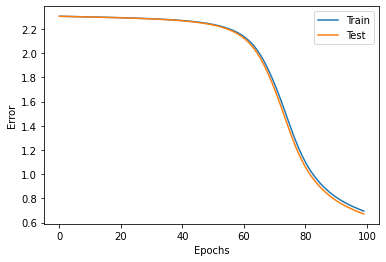

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(len(rec_loss_train)), rec_loss_train, label="Train")
plt.plot(range(len(rec_loss_test)), rec_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## 正解率

In [19]:
correct = 0
total = 0
for i, (x_train, y_train) in enumerate(test_loader):
    X, Y = x_train.cuda(), y_train.cuda()  # GPU対応
    X = X.view(-1, image_size*image_size)
    y_hat = model(X)
    correct += (y_hat.argmax(1) == Y).sum().item()
    total += len(X)
print("正解率:", str(correct/total*100) + "%")

正解率: 79.41%


# 解答例
以下は、どうしても手がかりがないときのみ参考にしましょう。

In [ ]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

# 訓練データを取得
mnist_train = MNIST("./data", 
                    train=True, download=True,
                    transform=transforms.ToTensor())
# テストデータの取得
mnist_test = MNIST("./data",
                   train=False, download=True,
                   transform=transforms.ToTensor())
print("訓練データの数:", len(mnist_train), "テストデータの数:", len(mnist_test))

# DataLoaderの設定
img_size = 28
batch_size = 128
# ------- 以下にコードを書く -------
train_loader = DataLoader(mnist_train, 
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(mnist_test,
                         batch_size=batch_size,
                         shuffle=False)
# ------- ここまで -------

In [ ]:
from torch import optim
import time

# 交差エントロピー誤差関数
loss_fnc = nn.CrossEntropyLoss()

# SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失のログ
record_loss_train = []
record_loss_test = []

# 学習
for i in range(10):  # 10エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ← 左にfor文のコードを追記
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # 評価モード
    loss_test = 0
    for j, (x, t) in enumerate(test_loader):  # ← 左にfor文のコードを追記
        x, t = x.cuda(), t.cuda()
        y = net(x)
        loss = loss_fnc(y, t)
        loss_test += loss.item()
    loss_test /= j+1
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)